In [2]:
import pandas as pd
import numpy as np
import os
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import seaborn as sns
from datetime import datetime

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization, Conv2D, Bidirectional, LSTM, TimeDistributed
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

In [3]:
window_size = 25
tf.random.set_seed(1)
np.random.seed(1)

## Getting the data

Before you run this, make sure that you have generated a sliding_windows file by running 01_sliding_windows.

In [4]:
data_path = '../data/'

In [5]:
final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth0_smallest25_size25_step25.csv')
final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth0_smallest25_size25_step25.csv')

smooth3_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth3_smallest25_size25_step25.csv')
smooth3_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth3_smallest25_size25_step25.csv')

smooth5_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth5_smallest25_size25_step25.csv')
smooth5_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth5_smallest25_size25_step25.csv')

smooth7_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth7_smallest25_size25_step25.csv')
smooth7_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth7_smallest25_size25_step25.csv')

In [6]:
smooth9_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth9_smallest25_size25_step25.csv')
smooth9_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth9_smallest25_size25_step25.csv')

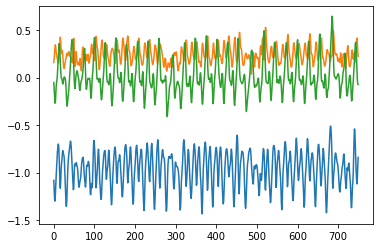

In [7]:
def plot_by_id(df, i): 
    plot_recording = df[df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
# plot_by_id(final_sliding_windows_respeck, 'Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43')
plot_by_id(smooth7_final_sliding_windows_thingy, 'Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07')

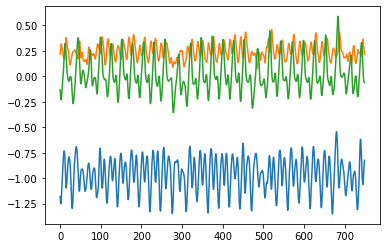

In [8]:
# plot_by_id(smooth7_final_sliding_windows_respeck, 'Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43')
plot_by_id(smooth9_final_sliding_windows_thingy, 'Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07')

## Some definitions

### Prepping the CNN model

In [9]:
def prep_cnn():
    print("Prepping CNN...")
    
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    #filters = [3, 7, 11]

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                     input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    #model.summary()
    
    model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])
    
    print("CNN prepped.")
    
    return model

In [10]:
# Wan et al. also used sinwod size 25, good for borrowing arch

def wan_cnn(save_to=None):
    """The kernel_sizes of each convolutional layer and pooling layer are 7, 3 and 1, 
    and the convolution depth (depth_size) is 64 steps, stride_size= 3, and batch_size= 64. 
    The number of hidden units in the fully connected layer is 512. During the training, 
    we used a dropout layer with the following parameters to prevent overfitting: 0.1, 0.25 and 0.5."""
    
    kernels = [7,3,1]
    dropouts = [0.1,0.25,0.5]
    f=64
    n_features = 6
    n_classes = len(class_labels)
    s=6
    
    model = Sequential()

    model.add(Conv1D(filters=f, kernel_size=kernels[0],
                     input_shape=(window_size, n_features)))
    #They don't mention activation method
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[0]))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[1]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[1]))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[2]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[2]))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'], strides=s)
    
    #save_to_models_comparisons('wan_et_al.txt', model.summary())
    print(model.summary())
    
    return model

In [11]:
def promising_cnn():
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    #model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()

    model.compile(
            optimizer=optimizers.Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
    
    return model

In [12]:
def promising_cnn_tinkering(filters=64, kernel_size=3):
    filters = filters
    kernel_size = kernel_size
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()

    model.compile(
            optimizer=optimizers.Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
    
    return model

In [13]:
def try_lstm(lstm_units=128, nn_units=128, dropout=0.5, learning_rate=0.01):
    n_features = 6
    n_classes = len(class_labels)
    
    model = Sequential()
    model.add(
        Bidirectional(
          LSTM(
              units=lstm_units,
              input_shape=(window_size, n_features)
          )
        )
    )
    model.add(Dropout(rate=dropout))
    model.add(Dense(units=nn_units, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizers.Adam(lr=learning_rate),
      metrics=['acc']
    )
    
    return model

In [14]:
def cnn_lstm():
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    
    # define CNN model
    cnn = Sequential()
    cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    cnn.add(MaxPooling1D())
    cnn.add(Flatten())
    
    # define LSTM model
    model = Sequential()
    model.add(TimeDistributed(cnn))
    """
    model.add(
        Bidirectional(
          LSTM(
              units=128,
              input_shape=(1,704)
          )
        )
    )
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['acc']
    )
    """
    
    return cnn

In [15]:
def try_cnn_lstm():
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    
    model = Sequential([
          Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)),
        MaxPooling1D(),
        Conv1D(filters=filters, kernel_size=kernel_size, activation=activation),
        MaxPooling1D(),
           Bidirectional(LSTM(units=128)),
        Flatten(),
        Dropout(rate=0.5),
          Dense(units=128, activation='relu'),
        Dense(n_classes, activation='softmax')])
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['acc']
    )
    
    return model

In [16]:
# multi-headed cnn model
# https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

def multi_head_cnn(trainX, trainy, testX, testy):
    k1_size, k2_size, k3_size = 3, 5, 11 # 56 / 86
#     k1_size, k2_size, k3_size = 2, 3, 7 # 59 / 89
    filters = 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=filters, kernel_size=k1_size, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=filters, kernel_size=k2_size, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=filters, kernel_size=k3_size, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [17]:
def save_to_models_comparisons(save_to, text):
    model_dir = 'models/comparisons/'
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
        
    f = open(model_dir + save_to, "a")
    f.write(text)
    f.close()

### Format the input

Format data into windows - make (window_size,6) inputs

In [18]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [19]:
class_labels = {
    'Sitting': 0,
    'Sitting bent forward': 1,
    'Sitting bent backward': 2,
    'Standing': 3,
    'Lying down left': 4,
    'Lying down right': 5,
    'Lying down on stomach': 6,
    'Lying down on back': 7,
    'Walking at normal speed': 8,
    'Running': 9,
    'Climbing stairs': 10,
    'Descending stairs': 11,
    'Desk work': 12,
    'Movement': 13,
    'Falling on knees': 14,
    'Falling on the back': 15,
    'Falling on the left': 16,
    'Falling on the right': 17
}

In [20]:
def format_data(X_train_full, y_train_full, X_test_full, y_test_full):
    
    print("Formatting data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     X_test_full = X_test_full[y_test_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_test_full = y_test_full[y_test_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_test = y_test_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)
    
    X_train = []
    X_test = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (window_size, len(columns_of_interest)):
            X_train.append(group[columns_of_interest].values)

    for window_id, group in X_test_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")

        X_test.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    X_test = np.asarray(X_test)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(X_test))

    print(np.shape(y_train))
    print(np.shape(y_test))
    
    print("Data formatted.")
    return X_train, y_train, X_test, y_test

In [21]:
def format_all_data(X_train_full, y_train_full):
    # to be used when we only want a training set not test set
    
    print("Formatting data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    
    X_train = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (window_size,len(columns_of_interest)):
            X_train.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(y_train))
    
    print("Data formatted.")
    return X_train, y_train

### Accuracy of the model (+ on subset)

In [22]:
# This is used for grouping the predictions into subsets
activity_groups = {
 'Sitting/Standing': [0,1,2,3,12], # including desk work
 'Lying': [4,5,6,7],
 'Walking': [8,10,11,13], # I include up and down stairs in this one + movement
 'Running': [9],
 'Falling': [14,15,16,17]
}
    
def group_y(y):
    grouped_y = []
    for yy in y:
        group = [i for i,v in enumerate(activity_groups.values()) if yy in v][0]
        grouped_y.append(group)
    return grouped_y

In [23]:
def evaluate(y_true_labels, y_pred_labels, save_to=None):
    print('\n')
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(y_true_labels, y_pred_labels))
    
    # compute accuracy of the subset of activities 
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)

    print('\n')
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(grouped_y_true_labels, grouped_y_pred_labels))

In [24]:
def confusion_mat(y_true_labels, y_pred_labels):
    confusion_matrix = tf.math.confusion_matrix(
        y_true_labels, y_pred_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,
        name=None
    )
    
    sns.heatmap(confusion_matrix, annot=True, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())

## Without Cross-validation for development

In [25]:
def prep_dev_data(final_sliding_windows):

    # split data into training and test sets (split by subject)

    subjects = final_sliding_windows['subject_id'].unique()

    train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, train_size=0.8)

    X_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + columns_of_interest]
    y_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + ['activity_type']]
    
    X_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + columns_of_interest]
    y_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + ['activity_type']]
    
    # format the data
    X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
    
    return X_train, y_train, X_test, y_test

In [26]:
def train_dev_model(model, X_train, y_train, batch_size=100, epochs=10):

    # train the model 
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    
    return model

In [27]:
# Prep data
X_train, y_train, X_test, y_test = prep_dev_data(final_sliding_windows_thingy)

Formatting data...
(19625, 25, 6)
(4425, 25, 6)
(19625, 18)
(4425, 18)
Data formatted.


In [28]:
# # Prep data
# X_train, y_train, X_test, y_test = prep_dev_data(final_sliding_windows_thingy)

# prepare the model
model = try_cnn_lstm()
# model = multi_head_cnn(X_train, y_train, X_test, y_test)

# Train 
model = train_dev_model(model, X_train, y_train, batch_size=64, epochs=10)
#train multi head cnn - 3 inputs
# model = train_dev_model(model, [X_train, X_train, X_train], y_train, batch_size=64, epochs=10)    

# Test the model
y_pred_ohe = model.predict(X_test)
# test multi head cnn - 3 inputs
# y_pred_ohe = model.predict([X_test, X_test, X_test])
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

evaluate(y_true_labels, y_pred_labels)

2021-11-18 15:00:10.539510: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-18 15:00:10.539985: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-18 15:00:10.542048: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-11-18 15:00:11.245679: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-18 15:00:11.266188: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099940000 Hz


Epoch 1/10
307/307 [==============================] - 14s 32ms/step - loss: 1.9881 - acc: 0.3378
Epoch 2/10
307/307 [==============================] - 12s 39ms/step - loss: 1.2227 - acc: 0.5649
Epoch 3/10
307/307 [==============================] - 12s 40ms/step - loss: 1.0580 - acc: 0.6213
Epoch 4/10
307/307 [==============================] - 14s 44ms/step - loss: 0.9664 - acc: 0.6530
Epoch 5/10
307/307 [==============================] - 13s 44ms/step - loss: 0.8950 - acc: 0.6772
Epoch 6/10
307/307 [==============================] - 11s 36ms/step - loss: 0.8529 - acc: 0.6864
Epoch 7/10
307/307 [==============================] - 12s 38ms/step - loss: 0.7821 - acc: 0.7159
Epoch 8/10
307/307 [==============================] - 10s 33ms/step - loss: 0.7345 - acc: 0.7284
Epoch 9/10
307/307 [==============================] - 14s 44ms/step - loss: 0.6829 - acc: 0.7476
Epoch 10/10
307/307 [==============================] - 16s 51ms/step - loss: 0.6685 - acc: 0.7520 1s


************************

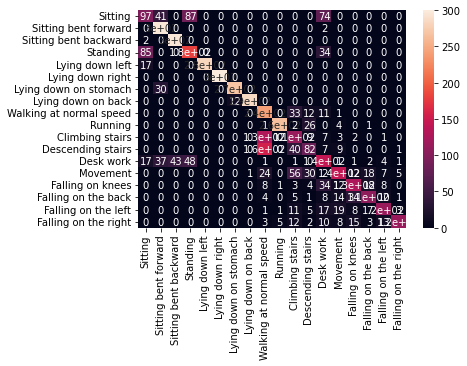

In [217]:
confusion_mat(y_true_labels, y_pred_labels)

## Train baseline model on ALL data

In [161]:
# Note: On Thingy
X = final_sliding_windows_thingy[['window_id'] + columns_of_interest]
y = final_sliding_windows_thingy[['window_id'] + ['activity_type']]

# format the data
X_train, y_train = format_all_data(X, y)
   
# prepare the CNN
model = prep_cnn()

# train the model 
train_dev_model(X_train, y_train)

Formating data...
(30267, 20, 6)
(30267, 18)
Data formatted.
Prepping CNN...
CNN prepped.


## Leave-One-Subject-Out Cross Validation

In [29]:
def get_loocv(final_sliding_windows, n=6):

    loocv = LeaveOneGroupOut()

    # # UNCOMMENT TO LEAVE ONE SUBJECT OUT####
    # # group by subject id so that one subject is left out each time
    # groups = final_sliding_windows['subject_id']
    # ########################################

    # UNCOMMENT TO LEAVE (48 / N) SUBJECTS OUT####
    # n must be a factor of 48 (there are 48 subjects in the dataset)
    #n = 6
    subj_group_mapping = {}
    for i, subj_id in enumerate(final_sliding_windows['subject_id'].unique()):
        subj_group_mapping[subj_id] = i % n
    groups = [ subj_group_mapping[subj_id] for subj_id in final_sliding_windows['subject_id'] ]
    ########################################

    X = final_sliding_windows[['window_id'] + columns_of_interest]
    y = final_sliding_windows[['window_id'] + ['activity_type']]

    # how many different subjects
    loocv.get_n_splits(X, y, groups)
    
    return loocv, X, y, groups

In [30]:
def run_cross_val(final_sliding_windows, model_setup, params={}, n=4,  batch_size=32, epochs=10):
    loocv, X, y, groups = get_loocv(final_sliding_windows, n=n)

    y_pred_labels = np.empty(shape=(0,))
    y_true_labels = np.empty(shape=(0,))
    
    trained_models = [] # For epoch experiments

    # this gives a train/test split that leaves one subject out in each iteration
    for i, (train_index, test_index) in enumerate(loocv.split(X, y, groups)):
        print("Starting iteration " + str(i) + ' of ' + str(n))

        X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test_full = y.iloc[train_index], y.iloc[test_index]

        X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)

        model = model_setup(**params)

        print("Training...")
        trained = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
        trained_models.append(trained)
        
        # stats
        y_pred_ohe = model.predict(X_test)
        y_pred_labels = np.concatenate([y_pred_labels, np.argmax(y_pred_ohe, axis=1)])
        y_true_labels = np.concatenate([y_true_labels, np.argmax(y_test, axis=1)])

        print(y_pred_labels.shape)
        print(y_true_labels.shape)

    evaluate(y_true_labels, y_pred_labels)
    
    confusion_mat(y_true_labels, y_pred_labels)
    
    return y_true_labels, y_pred_labels, trained_models 

In [99]:
# Running cross-val
params = {'lstm_units':64, 'nn_units':64}
_, _, ms = run_cross_val(final_sliding_windows_respeck, try_lstm, params, epochs=2, n=2)

Starting iteration 0 of 2
Formatting data...
(11901, 25, 6)
(12378, 25, 6)
(11901, 18)
(12378, 18)
Data formatted.
Training...
Epoch 1/2


NotImplementedError: in user code:

    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/layers/wrappers.py:539 __call__
        return super(Bidirectional, self).__call__(inputs, **kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/layers/wrappers.py:653 call
        initial_state=forward_state, **kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1157 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:859 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:643 get_initial_state
        inputs=None, batch_size=batch_size, dtype=dtype)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:2507 get_initial_state
        self, inputs, batch_size, dtype))
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:2987 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:3003 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/util/nest.py:659 map_structure
        structure[0], [func(*x) for x in entries],
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/util/nest.py:659 <listcomp>
        structure[0], [func(*x) for x in entries],
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:3000 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2819 wrapped
        tensor = fun(*args, **kwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2868 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2804 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:6 prod
        
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3031 prod
        keepdims=keepdims, initial=initial, where=where)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:855 __array__
        " a NumPy call, which is not supported".format(self.name))

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_7/bidirectional_2/forward_lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


## Tuning

In [31]:
# Tuning try_lstm
kernels= [2,3]
filters = [16, 32,64,128]
dropouts = [0.0, 0.1, 0.3, 0.5]
lstm_units = [16,32,64,128,256]
nn_units = [32,64,128,256]
batch_sizes = [32, 64, 128, 256]
cnn_epochs = 20
learning_rates = [0.1, 0.01]
lstm_epochs = 10
multihead_kernels = [2,3,5,7,9,11]

In [32]:
comparison_save_dir = 'models/comparisons/'

if not os.path.isdir(comparison_save_dir):
    os.mkdirs(comparison_save_dir)

### Functions and prep data

In [33]:
def get_cv_data(final_sliding_windows, n=3):
    loocv, X, y, groups = get_loocv(final_sliding_windows, n=n)

    y_pred_labels = np.empty(shape=(0,))
    y_true_labels = np.empty(shape=(0,))
    
    #trained_models = [] # For epoch experiments
    X_trains = []
    y_trains = []
    X_tests = []
    y_tests = []

    # this gives a train/test split that leaves one subject out in each iteration
    for i, (train_index, test_index) in enumerate(loocv.split(X, y, groups)):
        print("Starting iteration " + str(i) + ' of ' + str(n))

        X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test_full = y.iloc[train_index], y.iloc[test_index]

        X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
        
        # Yes this is very inefficient space-wise but it is to save time! 
        X_trains.append(X_train)
        y_trains.append(y_train)
        X_tests.append(X_test)
        y_tests.append(y_test)
        
        #df, trained_models = loopparas
    
    return X_trains, y_trains, X_tests, y_tests

In [34]:
def run_model_on_split(X_train, y_train, X_test, y_test, model_setup, params={}, batch_size=64, epochs=10, verbose=0):
    model = model_setup(**params)
    trained = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose)

    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    
    full_acc = accuracy_score(y_true_labels, y_pred_labels)
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)
    subset_acc = accuracy_score(grouped_y_true_labels, grouped_y_pred_labels)
    
    return full_acc, subset_acc

In [35]:
def epoch_testing(X_train, y_train, X_test, y_test, model_setup, params={}, epochs=10, batch_size=64, verbose=0):
    model = model_setup(**params)
    trained = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return trained

In [46]:
# Get the train and test splits for each cross val
X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_thingy)

Starting iteration 0 of 3
Formatting data...
(16274, 25, 6)
(7776, 25, 6)
(16274, 18)
(7776, 18)
Data formatted.
Starting iteration 1 of 3
Formatting data...
(15915, 25, 6)
(8135, 25, 6)
(15915, 18)
(8135, 18)
Data formatted.
Starting iteration 2 of 3
Formatting data...
(15911, 25, 6)
(8139, 25, 6)
(15911, 18)
(8139, 18)
Data formatted.


### Tune Epochs and Dropout rate

Make sure that the model setup function has defaults specified for everything!

In [119]:
# TODO: Save to file

model_setup = try_lstm
epochs = lstm_epochs
n=3 # Must be same as used in get_cv_data!
save_file = 'try_lstm_epochs_dropouts.txt'
results = ''

for dropout in dropouts:
    params = {'dropout':dropout} # Otherwise run with default parameters
    print(params)
    for i in range(n):
        print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
        try:
            trained_model = epoch_testing(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, verbose=1, params=params, epochs=epochs)
            results += str(params) + ' iteration ' + str(i) + '\n'
            results += 'Training accuracy: ' + str(trained_model.history['acc']) + '\n'
            results += 'Validation accuracy: ' + str(trained_model.history['acc']) + '\n\n'
        except Exception as ex:
            print('\tException: ' +  str(ex))
        
print('Saving to ' + comparison_save_dir + save_file)
with open(comparison_save_dir + save_file, "w") as text_file:
    text_file.write(results)

{'dropout': 0.0}
	Iteration 0 @ 15:02:30
Train on 14858 samples, validate on 8243 samples
Epoch 1/2
14858/14858 [==============================] - 48s 3ms/sample - loss: 1.2782 - acc: 0.5532 - val_loss: 1.6758 - val_acc: 0.4552
Epoch 2/2
14858/14858 [==============================] - 50s 3ms/sample - loss: 1.0450 - acc: 0.6278 - val_loss: 1.6866 - val_acc: 0.4773
	Iteration 1 @ 15:04:09
Train on 15463 samples, validate on 7638 samples
Epoch 1/2
 6208/15463 [===========>..................] - ETA: 32s - loss: 1.8026 - acc: 0.3810

KeyboardInterrupt: 

### Tune model parameters

Make sure to run get_cv_data first

In [99]:
# Save experiment setting to file

n=3 # Cross-val n used in get_cv_data
model_setup = try_lstm # Change this

# Set these from epoch experiment (Change this)
epochs = 2
dropout = 0.5
save_file = 'try_lstm_parameter_search.csv' # Change this

# Create list for saving configurations and accuracies
results = []
columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# LSTM
# Change loops
for lstm_unit in lstm_units:
    for nn_unit in nn_units:
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                # Change this
                params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
                print('\n' + str(params) + ', batch size: ' + str(batch_size))
                accs = []
                saccs = []
                for i in range(n):
                    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
                    try:
                        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
                        accs.append(acc)
                        saccs.append(sacc)
                        
                    except Exception as ex:
                        print('\tException: ' +  str(ex))
                    
                # Change this - must match columns!
                results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])

# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)


{'dropout': 0.5, 'lstm_units': 16, 'nn_units': 32, 'learning_rate': 0.1}, batch size: 32
	Iteration 0 @ 14:52:54
	Iteration 1 @ 14:53:14


KeyboardInterrupt: 

### Smoothing experiment - promising CNN

In [132]:
# Save experiment setting to file

n=3 # Cross-val n used in get_cv_data
model_setup = promising_cnn # Change this

# Set these from epoch experiment (Change this)
epochs = 10
# dropout = 0.5
batch_size = 64
save_file = 'respeck_promising_cnn_smooth9.csv' # Change this

# Create list for saving configurations and accuracies
results = []
# columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns = ['epochs', 'batch_size'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# Change this
# params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
# print('\n' + str(params) + ', batch size: ' + str(batch_size))
params = {}
accs = []
saccs = []
for i in range(n):
    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
    try:
        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
        accs.append(acc)
        saccs.append(sacc)

    except Exception as ex:
        print('\tException: ' +  str(ex))

# Change this - must match columns!
# results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])
results.append([epochs, batch_size, np.mean(accs), np.mean(saccs)])


# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)

	Iteration 0 @ 14:40:32
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 11, 64)            256       
_________________________________________________________________
activation_96 (Activation)   (None, 11, 64)            0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_97 (Batc 

### Smoothing experiment - try lstm

In [47]:
# Save experiment setting to file

n=3 # Cross-val n used in get_cv_data
model_setup = try_lstm # Change this

# Set these from epoch experiment (Change this)
epochs = 5
# dropout = 0.5
batch_size = 64
save_file = 'thingy_try_lstm_smooth0.csv' # Change this

# Create list for saving configurations and accuracies
results = []
# columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns = ['epochs', 'batch_size'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# Change this
# params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
# print('\n' + str(params) + ', batch size: ' + str(batch_size))
params = {}
accs = []
saccs = []
for i in range(n):
    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
    try:
        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
        accs.append(acc)
        saccs.append(sacc)

    except Exception as ex:
        print('\tException: ' +  str(ex))

# Change this - must match columns!
# results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])
results.append([epochs, batch_size, np.mean(accs), np.mean(saccs)])


# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)

	Iteration 0 @ 15:56:05
	Iteration 1 @ 15:58:44
	Iteration 2 @ 16:01:36
Saving to models/comparisons/thingy_try_lstm_smooth0.csv


### Save a test instance

In [41]:
for i in range(5):
    print(y_test[i])
    #np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [42]:
for i in np.arange(15,20):
    print(y_test[i])
    np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Save to file and convert to tflite

In [123]:
# Saving the model to file
model_name = 'cnn_simple_full_thingy'

export_dir = 'models\\' + model_name
tf.saved_model.save(model,export_dir)

# Convert the saved tensorflow model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the tensorflow lite model to file
import pathlib
tflite_model_file = pathlib.Path('models/' + model_name + '.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: models\cnn_simple_full_thingy\assets


473324